# CNN Classificators

In [57]:
import pandas as pd
import numpy as np
import re
#import nltk
#from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
#from keras.layers.core import Activation, Dropout, Dense
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

#import nltk
from numpy import asarray
from numpy import zeros
from keras.layers import Conv1D
import seaborn as sns

from datasets import load_dataset
import panel as pn
import warnings; warnings.filterwarnings('ignore')
from datasets import Dataset,DatasetDict,Features,Value,ClassLabel
from keras.callbacks import EarlyStopping
from torch.nn import ReLU
from keras.layers import MaxPooling1D 

import matplotlib.pyplot as plt
from stop_words import get_stop_words

For this section, we implement a binary classification (positive/negative) and a multiclass classification (sadness, anger, love, surprise, fear, joy).

We introduce a second data set of movies reviews to be used for training the binary classifier, while the previously used dataset will still be used for the multiclass classification.

We will later analyze the predictions of both classifiers in both datasets to assess the distribution of multi-class feelings in the binary perception of the comment. In theory, our initial assumption is that sadness and anger should mostly match the negative binary classification, joy, and love should match the positive one, and perhaps surprise and fear could be more sparse among the classes.

## Data preparation

### Movies Reviews Dataset for Binary Classification

The maximum number of words in the movies dataset  is: 2470


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


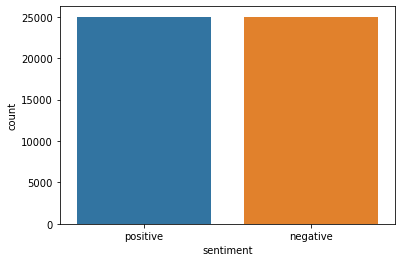

In [24]:
# Load the dataset into a DataFrame
movies_file_path = r'.\data\IMDB_Dataset.csv'
movie_reviews = pd.read_csv(movies_file_path)

#Remove nulls
movie_reviews.isnull().values.any()

#Show class distribution
sns.countplot(x='sentiment', data=movie_reviews)

max_words_count_movies = movie_reviews['review'].apply(lambda x: len(x.split())).max()
print(f"The maximum number of words in the movies dataset  is: {max_words_count_movies}")

movie_reviews

### Feelings Comments Dataset for Multiclass Classification

The original dataset was retrieved from https://huggingface.co/datasets/dair-ai/emotion. Further preprocessing was made to remove nulls and add the sentiment label name.

The maximum number of words in the feelings dataset is: 66


,text,label,sentiment
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


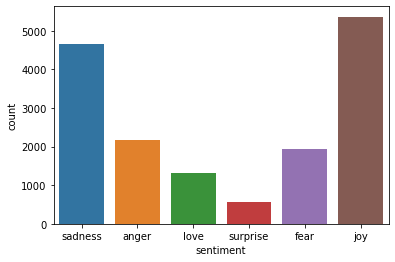

In [25]:
# Load the dataset into a DataFrame
feelings_file_path = r'.\data\preprocessed_feelings-training.csv'
feelings_train = pd.read_csv(feelings_file_path)

#Remove nulls
feelings_train.isnull().values.any()

#Show class distribution
sns.countplot(x='sentiment', data=feelings_train)

max_words_count_feelings = feelings_train['text'].apply(lambda x: len(x.split())).max()
print(f"The maximum number of words in the feelings dataset is: {max_words_count_feelings}")

feelings_train

### Preprocessing functions

For CNN, it is necessary to remove certain elements from the text such as stopwords and punctuations, since this will only introduce noise considering that this algorithm is not capable of inferring the context given by these elements. To do so, we use the functions below.

In [26]:
# The following code is adapted from the sentiment-analysis-with-deep-neural-networks repository by SkillCate
# Repository URL: https://github.com/skillcate/sentiment-analysis-with-deep-neural-networks
#----------

TAG_RE = re.compile(r'<[^>]+>')
stop_words = get_stop_words('english')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)


#nltk.download('stopwords')

def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

#----------

In [27]:
word_tokenizer = Tokenizer()

def prepare_datasets(df, X, y, maxlen):
    
    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
    #Prepare embedding layer
    # Train the tokenizer 
    word_tokenizer.fit_on_texts(X_train)

    # Convert sentences to their numeric form
    X_train = word_tokenizer.texts_to_sequences(X_train)
    X_test = word_tokenizer.texts_to_sequences(X_test)

    # Adding 1 to store dimensions for words for which no pretrained word embeddings exist
    vocab_length = len(word_tokenizer.word_index) + 1

    # Padding all reviews to have the same length
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
    #padding='post' --> adds padding after the sentence
    #maxlen set to the max number of words to assure all sentences to fit and to have same lenght and

    # Load GloVe word embeddings and create an Embeddings Dictionary
    embeddings_dictionary = dict()
    glove_file = open(r'.\a2_glove.6B.100d.txt', encoding="utf8")

    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions
    glove_file.close()

    # Create Embedding Matrix having 100 columns 
    # Containing 100-dimensional GloVe word embeddings for all words in our corpus.
    embedding_matrix = zeros((vocab_length, 100))
    for word, index in word_tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    
    embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
    #100 dimensions --> the Glove emmbedding we use has 100 dimensions, so we keep the same number
    #trainable=False to allow Transfer learning: keep semantic information from pre-trained embeddings from GloVe. 

    return embedding_layer, X_train, X_test, y_train, y_test

## Binary Classification

In [59]:
class_mapping = {1: 'positive', 0: 'negative'}

# Calling preprocessing_text function on movie_reviews
X_movies = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X_movies.append(preprocess_text(sen))

# Converting sentiment labels to 0 & 1
y_movies = movie_reviews['sentiment']
y_movies = np.array(list(map(lambda x: 1 if x=="positive" else 0, y_movies)))
 
# Check the lengths of X and y
print("Number of  X:", len(X_movies))
print("Number of y:", len(y_movies))
print("DF:", movie_reviews.shape)

movies_embedding_layer, movies_X_train, movies_X_test, movies_y_train, movies_y_test = prepare_datasets(movie_reviews, X_movies, y_movies, max_words_count_movies)

Number of  X: 50000
Number of y: 50000
DF: (50000, 2)


In [60]:
def evaluate_Binary_CNN(model, model_history, X_test, y_test):
    
    score = model.evaluate(X_test, y_test, verbose=1)
    # Model Performance

    print("Test Score:", score[0])
    print("Test Accuracy:", score[1])

    # Model Performance Charts

    import matplotlib.pyplot as plt

    plt.plot(model_history.history['acc'])
    plt.plot(model_history.history['val_acc'])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.show()

    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.show()
    return score

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2470, 100)         9391700   
                                                                 
 conv1d_23 (Conv1D)          (None, 2466, 128)         64128     
                                                                 
 global_max_pooling1d_19 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_20 (Dense)            (None, 1)                 129       
                                                                 
Total params: 9455957 (36.07 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9391700 (35.83 MB)
_________________________________________________________________
None
Epoch 1/6
1000/1000 [==============================] - 157s 156ms/step

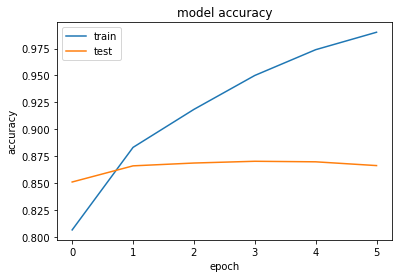

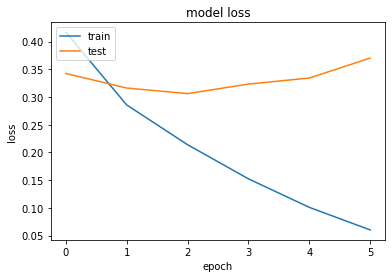

[0.36375418305397034, 0.8636999726295471]

In [61]:
def train_Binary_CNN_Original(embedding_layer, X_train, y_train, filters=128, kernel = 5, epochs =6):
    cnn_model = Sequential()
    cnn_model.add(embedding_layer)
    
    #add a 1D convolutional layer
    # padding was pre-done so no need for further modifications on it
    #filters = 128 --> number of patterns to learn
    #kernel_size = 5 ---> words considered at once
    #ReLu --> to introduce non linearity 
    cnn_model.add(Conv1D(filters, kernel, activation='relu'))
    
    #Extract most important feature, Maxpool shows better performance for NLP
    #Samat, Nurul Ashikin & Salleh, Mohd & Ali, Haseeb. (2020). The Comparison of Pooling Functions in Convolutional Neural Network for Sentiment Analysis Task. 10.1007/978-3-030-36056-6_20. 
    cnn_model.add(GlobalMaxPooling1D()) 
    
    cnn_model.add(Dense(1, activation='sigmoid'))
    #Only 1 output layer needed for binary classification
    #Sigmoid activation function squashes the output to the range [0, 1]

    # Model compiling
    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    print(cnn_model.summary())
    
    # Create an EarlyStopping callback
    #early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    # The 'patience' parameter determines the number of epochs with no improvement after which training will be stopped.
    # 'monitor' specifies the metric to monitor for improvement. In this case, it's validation loss.
    # 'restore_best_weights' restores the model weights from the epoch with the best value of the monitored quantity.
    
    
    # Train the model with the callback
    cnn_model_history = cnn_model.fit(X_train, y_train, epochs=epochs, validation_split=0.2)

    return cnn_model, cnn_model_history

cnn_model1, cnn_model_history1 = train_Binary_CNN_Original(movies_embedding_layer, movies_X_train, movies_y_train)
evaluate_Binary_CNN(cnn_model1, cnn_model_history1, movies_X_test, movies_y_test)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2470, 100)         9391700   
                                                                 
 conv1d_24 (Conv1D)          (None, 2466, 128)         64128     
                                                                 
 global_max_pooling1d_20 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_21 (Dense)            (None, 1)                 129       
                                                                 
Total params: 9455957 (36.07 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9391700 (35.83 MB)
_________________________________________________________________
None
Epoch 1/100
1000/1000 [==============================] - 156s 155ms/st

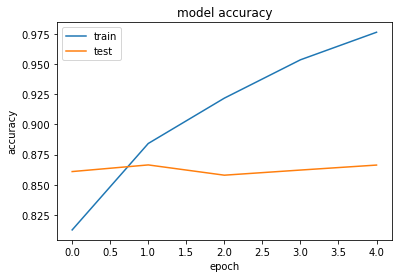

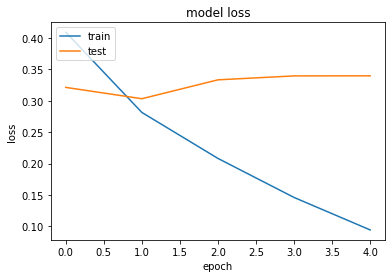

[0.30918261408805847, 0.8689000010490417]

In [62]:
def train_Binary_CNN_Original_earlystop(embedding_layer, X_train, y_train, filters=128, kernel = 5, epochs =6):
    cnn_model = Sequential()
    cnn_model.add(embedding_layer)
    
    #add a 1D convolutional layer
    # padding was pre-done so no need for further modifications on it
    #filters = 128 --> number of patterns to learn
    #kernel_size = 5 ---> words considered at once
    #ReLu --> to introduce non linearity 
    cnn_model.add(Conv1D(filters, kernel, activation='relu'))
    
    #Extract most important feature, Maxpool shows better performance for NLP
    #Samat, Nurul Ashikin & Salleh, Mohd & Ali, Haseeb. (2020). The Comparison of Pooling Functions in Convolutional Neural Network for Sentiment Analysis Task. 10.1007/978-3-030-36056-6_20. 
    cnn_model.add(GlobalMaxPooling1D()) 
    
    cnn_model.add(Dense(1, activation='sigmoid'))
    #Only 1 output layer needed for binary classification
    #Sigmoid activation function squashes the output to the range [0, 1]

    # Model compiling
    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    print(cnn_model.summary())
    
    # Create an EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    # The 'patience' parameter determines the number of epochs with no improvement after which training will be stopped.
    # 'monitor' specifies the metric to monitor for improvement. In this case, it's validation loss.
    # 'restore_best_weights' restores the model weights from the epoch with the best value of the monitored quantity.
    
    
    # Train the model with the callback
    cnn_model_history = cnn_model.fit(X_train, y_train, epochs=100, callbacks=[early_stopping], validation_split=0.2)

    return cnn_model, cnn_model_history

cnn_model2, cnn_model_history2 = train_Binary_CNN_Original_earlystop(movies_embedding_layer, movies_X_train, movies_y_train)
evaluate_Binary_CNN(cnn_model2, cnn_model_history2, movies_X_test, movies_y_test)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2470, 100)         9391700   
                                                                 
 conv1d_25 (Conv1D)          (None, 2466, 128)         64128     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 1233, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_26 (Conv1D)          (None, 1229, 128)         82048     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 614, 128)          0         
 g1D)                                                            
                                                                 
 global_max_pooling1d_21 (G  (None, 128)             

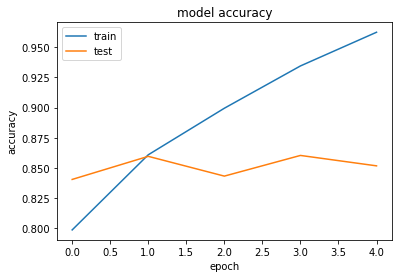

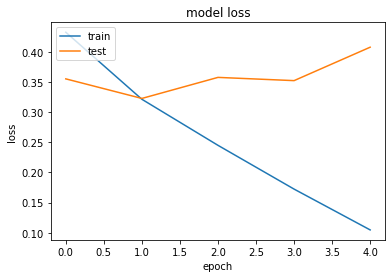

[0.3217719793319702, 0.8597999811172485]

In [63]:
def train_Binary_CNN(embedding_layer, X_train, y_train, filters=128, kernel=5, num_conv_layers=2, epochs=6):
    cnn_model = Sequential()
    cnn_model.add(embedding_layer)
    
    for _ in range(num_conv_layers):
        cnn_model.add(Conv1D(filters, kernel, activation='relu'))
        #Max Pooling reduces spatial dimensions and captures local features effectively. --> local info

        cnn_model.add(MaxPooling1D())
        
    #Global Max Pooling summarizes the most important global features.--> global info
    cnn_model.add(GlobalMaxPooling1D()) 
    
    cnn_model.add(Dense(1, activation='sigmoid'))

    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    print(cnn_model.summary())

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    cnn_model_history = cnn_model.fit(X_train, y_train, epochs=100, callbacks=[early_stopping], validation_split=0.2)

    return cnn_model, cnn_model_history

# Example usage with two convolutional layers
cnn_model3, cnn_model_history3 = train_Binary_CNN(movies_embedding_layer, movies_X_train, movies_y_train, num_conv_layers=2)
evaluate_Binary_CNN(cnn_model3, cnn_model_history3, movies_X_test, movies_y_test)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2470, 100)         9391700   
                                                                 
 conv1d_27 (Conv1D)          (None, 2466, 128)         64128     
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 1233, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_28 (Conv1D)          (None, 1229, 128)         82048     
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 614, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_29 (Conv1D)          (None, 610, 128)        

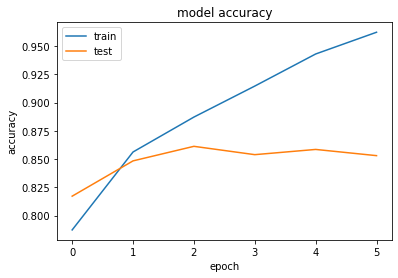

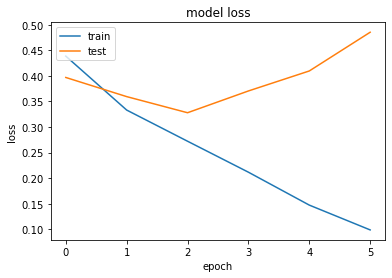

[0.32795166969299316, 0.8585000038146973]

In [64]:
# 4 convolution-pooling pairs
cnn_model4, cnn_model_history4 = train_Binary_CNN(movies_embedding_layer, movies_X_train, movies_y_train, num_conv_layers=4)
evaluate_Binary_CNN(cnn_model4, cnn_model_history4, movies_X_test, movies_y_test)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2470, 100)         9391700   
                                                                 
 conv1d_31 (Conv1D)          (None, 2466, 128)         64128     
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 1233, 128)         0         
 ng1D)                                                           
                                                                 
 conv1d_32 (Conv1D)          (None, 1229, 128)         82048     
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 614, 128)          0         
 ng1D)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 78592)           

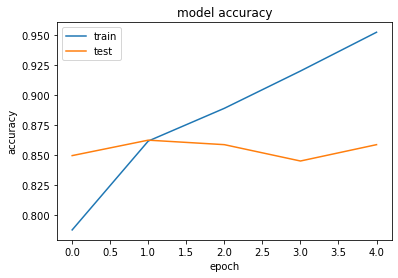

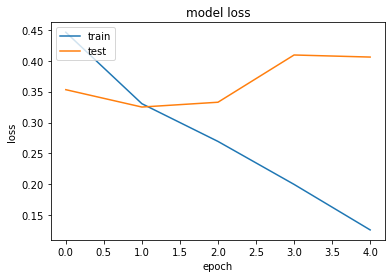

[0.32556065917015076, 0.8623999953269958]

In [65]:
from keras.layers import Flatten 

def train_Binary_CNN_flattening(embedding_layer, X_train, y_train, filters=128, kernel=5, num_conv_layers=2, epochs=6):
    cnn_model = Sequential()
    cnn_model.add(embedding_layer)
    
    for _ in range(num_conv_layers):
        cnn_model.add(Conv1D(filters, kernel, activation='relu'))
        cnn_model.add(MaxPooling1D())
    
    cnn_model.add(Flatten()) 
    
    cnn_model.add(Dense(1, activation='sigmoid'))

    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    print(cnn_model.summary())

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    cnn_model_history = cnn_model.fit(X_train, y_train, epochs=100, callbacks=[early_stopping], validation_split=0.2)

    return cnn_model, cnn_model_history

# Example usage with two convolutional layers + flattening instead of global maxpool
cnn_model5, cnn_model_history5 = train_Binary_CNN_flattening(movies_embedding_layer, movies_X_train, movies_y_train, num_conv_layers=2)
evaluate_Binary_CNN(cnn_model5, cnn_model_history5, movies_X_test, movies_y_test)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2470, 100)         9391700   
                                                                 
 conv1d_33 (Conv1D)          (None, 2468, 64)          19264     
                                                                 
 global_max_pooling1d_23 (G  (None, 64)                0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9411029 (35.90 MB)
Trainable params: 19329 (75.50 KB)
Non-trainable params: 9391700 (35.83 MB)
_________________________________________________________________
None
Epoch 1/100
1000/1000 [==============================] - 59s 58ms/step 

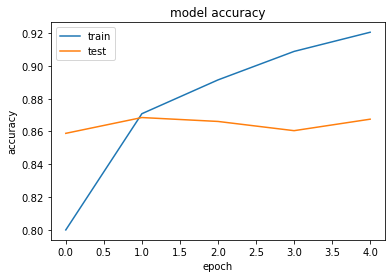

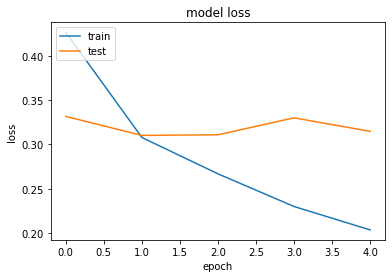

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2470, 100)         9391700   
                                                                 
 conv1d_34 (Conv1D)          (None, 2466, 64)          32064     
                                                                 
 global_max_pooling1d_24 (G  (None, 64)                0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9423829 (35.95 MB)
Trainable params: 32129 (125.50 KB)
Non-trainable params: 9391700 (35.83 MB)
_________________________________________________________________
None
Epoch 1/100
1000/1000 [==============================] - 85s 84ms/step

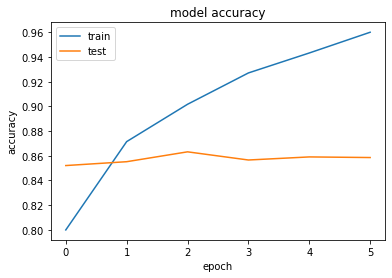

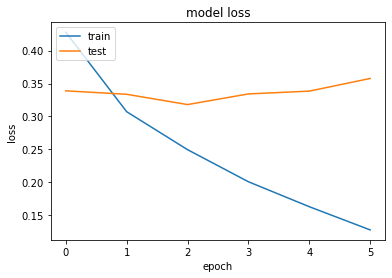

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2470, 100)         9391700   
                                                                 
 conv1d_35 (Conv1D)          (None, 2464, 64)          44864     
                                                                 
 global_max_pooling1d_25 (G  (None, 64)                0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_27 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9436629 (36.00 MB)
Trainable params: 44929 (175.50 KB)
Non-trainable params: 9391700 (35.83 MB)
_________________________________________________________________
None
Epoch 1/100
1000/1000 [==============================] - 105s 105ms/st

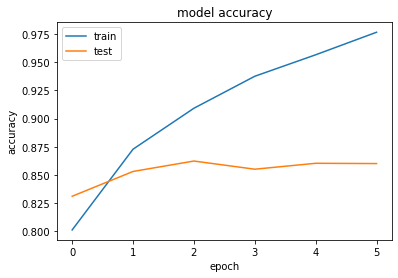

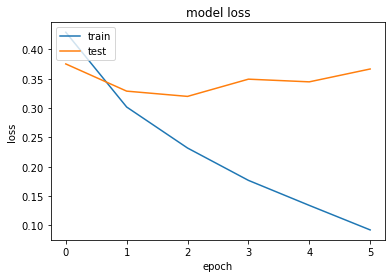

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2470, 100)         9391700   
                                                                 
 conv1d_36 (Conv1D)          (None, 2468, 128)         38528     
                                                                 
 global_max_pooling1d_26 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_28 (Dense)            (None, 1)                 129       
                                                                 
Total params: 9430357 (35.97 MB)
Trainable params: 38657 (151.00 KB)
Non-trainable params: 9391700 (35.83 MB)
_________________________________________________________________
None
Epoch 1/100
1000/1000 [==============================] - 110s 109ms/st

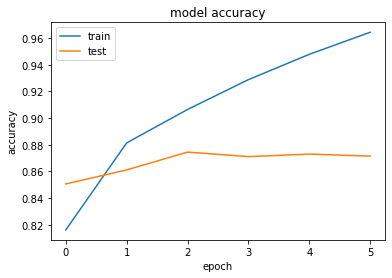

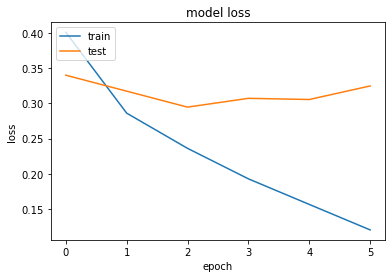

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2470, 100)         9391700   
                                                                 
 conv1d_37 (Conv1D)          (None, 2466, 128)         64128     
                                                                 
 global_max_pooling1d_27 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_29 (Dense)            (None, 1)                 129       
                                                                 
Total params: 9455957 (36.07 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9391700 (35.83 MB)
_________________________________________________________________
None
Epoch 1/100
1000/1000 [==============================] - 155s 155ms/st

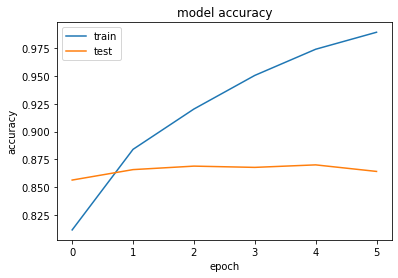

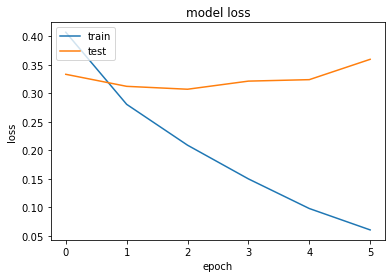

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2470, 100)         9391700   
                                                                 
 conv1d_38 (Conv1D)          (None, 2464, 128)         89728     
                                                                 
 global_max_pooling1d_28 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_30 (Dense)            (None, 1)                 129       
                                                                 
Total params: 9481557 (36.17 MB)
Trainable params: 89857 (351.00 KB)
Non-trainable params: 9391700 (35.83 MB)
_________________________________________________________________
None
Epoch 1/100
1000/1000 [==============================] - 195s 194ms/st

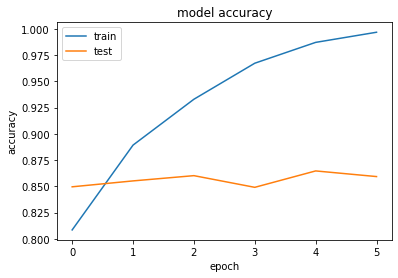

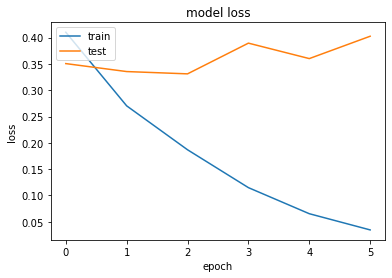

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2470, 100)         9391700   
                                                                 
 conv1d_39 (Conv1D)          (None, 2468, 256)         77056     
                                                                 
 global_max_pooling1d_29 (G  (None, 256)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_31 (Dense)            (None, 1)                 257       
                                                                 
Total params: 9469013 (36.12 MB)
Trainable params: 77313 (302.00 KB)
Non-trainable params: 9391700 (35.83 MB)
_________________________________________________________________
None
Epoch 1/100
1000/1000 [==============================] - 313s 312ms/st

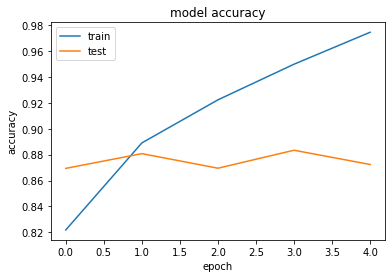

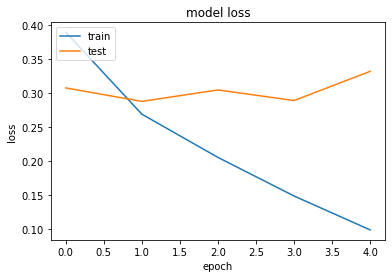

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2470, 100)         9391700   
                                                                 
 conv1d_40 (Conv1D)          (None, 2466, 256)         128256    
                                                                 
 global_max_pooling1d_30 (G  (None, 256)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_32 (Dense)            (None, 1)                 257       
                                                                 
Total params: 9520213 (36.32 MB)
Trainable params: 128513 (502.00 KB)
Non-trainable params: 9391700 (35.83 MB)
_________________________________________________________________
None
Epoch 1/100
1000/1000 [==============================] - 352s 351ms/s

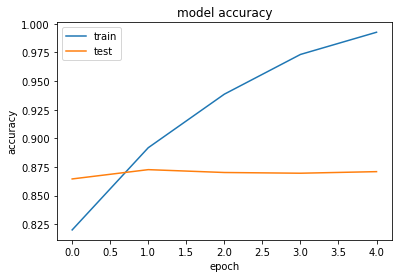

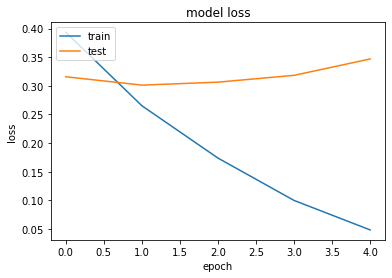

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2470, 100)         9391700   
                                                                 
 conv1d_41 (Conv1D)          (None, 2464, 256)         179456    
                                                                 
 global_max_pooling1d_31 (G  (None, 256)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_33 (Dense)            (None, 1)                 257       
                                                                 
Total params: 9571413 (36.51 MB)
Trainable params: 179713 (702.00 KB)
Non-trainable params: 9391700 (35.83 MB)
_________________________________________________________________
None
Epoch 1/100
1000/1000 [==============================] - 384s 383ms/s

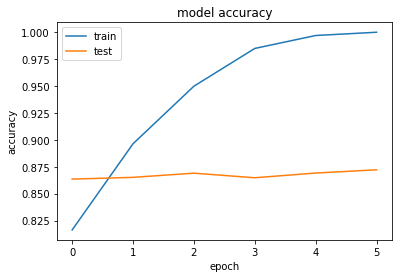

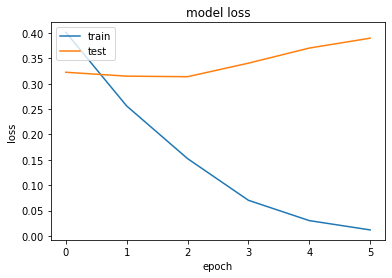

   Filters  Kernel_Size  Accuracy      Loss
0       64            3    0.8659  0.315642
1       64            5    0.8591  0.321995
2       64            7    0.8599  0.330753
3      128            3    0.8742  0.297925
4      128            5    0.8652  0.311775
5      128            7    0.8557  0.336927
6      256            3    0.8760  0.290941
7      256            5    0.8656  0.309868
8      256            7    0.8678  0.317418


In [66]:
def evaluate_hyperparameters(filter_values, kernel_sizes, X_train, y_train, X_test, y_test, embedding_layer):
    results = []

    for filters in filter_values:
        for kernel in kernel_sizes:
            model, history = train_Binary_CNN_Original_earlystop(embedding_layer, X_train, y_train, filters, kernel, epochs=6)
            evaluation = evaluate_Binary_CNN(model, history, X_test, y_test)
            accuracy = evaluation[1]  
            loss = evaluation[0] 

            # Store results in a dictionary
            result = {
                'Filters': filters,
                'Kernel_Size': kernel,
                'Accuracy': accuracy,
                'Loss': loss
               
            }
            results.append(result)

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Define ranges
filter_values = [64, 128, 256]
kernel_sizes = [3, 5, 7]

# Run the hyperparameter optimization and get the DataFrame
results_df = evaluate_hyperparameters(filter_values, kernel_sizes, movies_X_train, movies_y_train, movies_X_test, movies_y_test, movies_embedding_layer)
print(results_df)


## Multiclass Clasification

In [28]:
multiclass_df = feelings_train.copy()
multiclass_df.isnull().values.any()
multiclass_df = pd.get_dummies(multiclass_df, columns=['sentiment'], prefix='sentiment')
multiclass_df

,text,label,sentiment_anger,sentiment_fear,sentiment_joy,sentiment_love,sentiment_sadness,sentiment_surprise
0,i didnt feel humiliated,0,0,0,0,0,1,0
1,i can go from feeling so hopeless to so damned...,0,0,0,0,0,1,0
2,im grabbing a minute to post i feel greedy wrong,3,1,0,0,0,0,0
3,i am ever feeling nostalgic about the fireplac...,2,0,0,0,1,0,0
4,i am feeling grouchy,3,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,0,0,0,0,1,0
15996,i am now turning and i feel pathetic that i am...,0,0,0,0,0,1,0
15997,i feel strong and good overall,1,0,0,1,0,0,0
15998,i feel like this was such a rude comment and i...,3,1,0,0,0,0,0


In [29]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

maxlen = max_words_count_feelings

def prepare_multiclass_datasets(multiclass_df):
    X = []
    sentences = list(multiclass_df['text'])
    for sen in sentences:
        X.append(preprocess_text(sen))

    y = multiclass_df[['sentiment_anger', 'sentiment_fear', 'sentiment_joy', 'sentiment_love', 'sentiment_sadness', 'sentiment_surprise']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    # Tokenization and padding
    word_tokenizer.fit_on_texts(X_train)
    X_train = word_tokenizer.texts_to_sequences(X_train)
    X_test = word_tokenizer.texts_to_sequences(X_test)
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    vocab_length = len(word_tokenizer.word_index) + 1

    # Load GloVe word embeddings and create an Embeddings Dictionary
    embeddings_dictionary = dict()
    glove_file = open(r'.\a2_glove.6B.100d.txt', encoding="utf8")

    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

    glove_file.close()

    embedding_matrix = zeros((vocab_length, 100))
    for word, index in word_tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

    embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)

    return embedding_layer, X_train, X_test, y_train, y_test

embedding_layer_emotions, X_train_emotions, X_test_emotions, y_train_emotions, y_test_emotions = prepare_multiclass_datasets(multiclass_df)
y_train_emotions

,sentiment_anger,sentiment_fear,sentiment_joy,sentiment_love,sentiment_sadness,sentiment_surprise
676,0,0,1,0,0,0
12113,0,0,0,0,1,0
7077,0,0,0,1,0,0
13005,0,0,0,0,1,0
12123,1,0,0,0,0,0
...,...,...,...,...,...,...
13418,0,1,0,0,0,0
5390,0,0,0,1,0,0
860,0,0,0,0,1,0
15795,0,0,0,0,1,0


In [38]:
def evaluate_Multiclass_CNN(model, model_history, X_test, y_test):
    from tensorflow.math import confusion_matrix
    from seaborn import heatmap

    # Predict classes
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)
    #true_classes = np.argmax(y_test, axis=1)
    true_classes = np.argmax(np.array(y_test), axis=1)

    # Evaluate the model
    score = model.evaluate(X_test, y_test, verbose=1)
    print("Test Score:", score[0])
    print("Test Accuracy:", score[1])

    # Plot accuracy and loss
    plt.plot(model_history.history['acc'])
    plt.plot(model_history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 7))
    heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return score


In [35]:
y_test_emotions

,sentiment_anger,sentiment_fear,sentiment_joy,sentiment_love,sentiment_sadness,sentiment_surprise
8756,0,0,0,0,1,0
4660,0,0,1,0,0,0
6095,0,0,0,0,1,0
304,0,0,1,0,0,0
8241,0,0,0,0,1,0
...,...,...,...,...,...,...
15578,0,0,1,0,0,0
5746,0,0,1,0,0,0
6395,0,0,1,0,0,0
7624,0,0,1,0,0,0


In [51]:
def train_Multiclass_CNN_Original(embedding_layer, X_train, y_train, filters = 128, kernel = 5):
    # Define the model
    cnn_multiclass_model = Sequential()
    cnn_multiclass_model.add(embedding_layer)
    cnn_multiclass_model.add(Conv1D(filters, kernel, activation='relu'))
    cnn_multiclass_model.add(GlobalMaxPooling1D())
    cnn_multiclass_model.add(Dense(len(y_train.columns), activation='softmax')) #One output neuron per class

    # Compile the model
    cnn_multiclass_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

    # Train the model
    cnn_multiclass_model_history = cnn_multiclass_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

    return cnn_multiclass_model, cnn_multiclass_model_history

Epoch 1/6
80/80 [==============================] - 2s 17ms/step - loss: 1.4046 - acc: 0.4775 - val_loss: 1.1825 - val_acc: 0.5719
Epoch 2/6
80/80 [==============================] - 1s 9ms/step - loss: 0.9849 - acc: 0.6581 - val_loss: 0.9208 - val_acc: 0.6699
Epoch 3/6
80/80 [==============================] - 1s 12ms/step - loss: 0.7608 - acc: 0.7331 - val_loss: 0.7771 - val_acc: 0.7145
Epoch 4/6
80/80 [==============================] - 1s 11ms/step - loss: 0.6303 - acc: 0.7870 - val_loss: 0.6917 - val_acc: 0.7305
Epoch 5/6
80/80 [==============================] - 1s 11ms/step - loss: 0.5442 - acc: 0.8156 - val_loss: 0.6338 - val_acc: 0.7668
Epoch 6/6
100/100 [==============================] - 1s 3ms/step - loss: 0.5538 - acc: 0.7944
Test Score: 0.5537959337234497
Test Accuracy: 0.7943750023841858


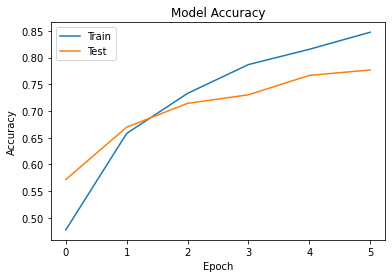

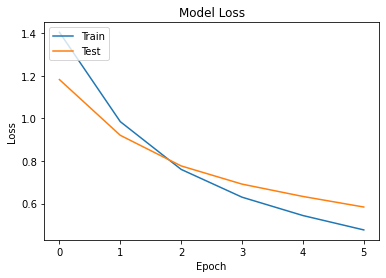

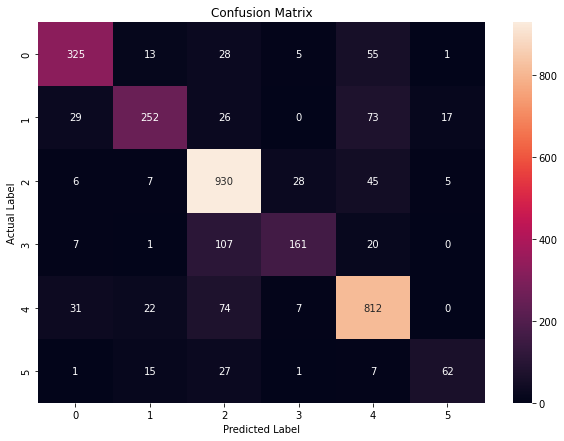

Epoch 1/6
80/80 [==============================] - 2s 15ms/step - loss: 1.3630 - acc: 0.4895 - val_loss: 1.1920 - val_acc: 0.5641
Epoch 2/6
80/80 [==============================] - 1s 9ms/step - loss: 0.9776 - acc: 0.6599 - val_loss: 0.9701 - val_acc: 0.6430
Epoch 3/6
80/80 [==============================] - 1s 9ms/step - loss: 0.7661 - acc: 0.7380 - val_loss: 0.8421 - val_acc: 0.6863
Epoch 4/6
80/80 [==============================] - 1s 9ms/step - loss: 0.6227 - acc: 0.7924 - val_loss: 0.7567 - val_acc: 0.7176
Epoch 5/6
80/80 [==============================] - 1s 9ms/step - loss: 0.5224 - acc: 0.8311 - val_loss: 0.6990 - val_acc: 0.7410
Epoch 6/6
100/100 [==============================] - 1s 4ms/step - loss: 0.6097 - acc: 0.7759
Test Score: 0.6096811294555664
Test Accuracy: 0.7759374976158142


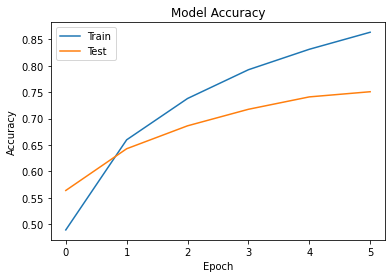

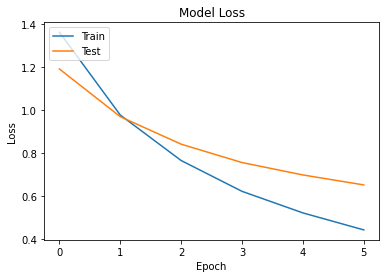

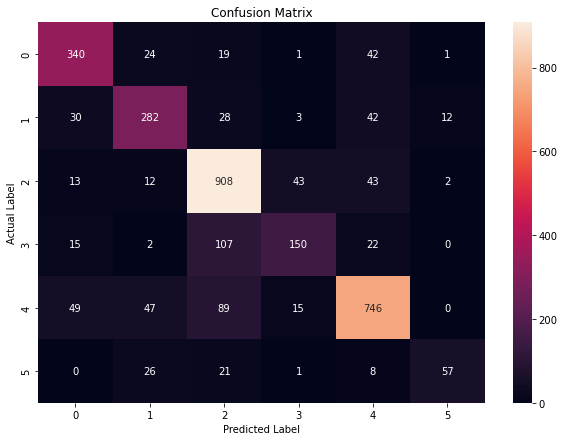

Epoch 1/6
80/80 [==============================] - 2s 22ms/step - loss: 1.3929 - acc: 0.4855 - val_loss: 1.2071 - val_acc: 0.5590
Epoch 2/6
80/80 [==============================] - 1s 14ms/step - loss: 0.9880 - acc: 0.6473 - val_loss: 0.9961 - val_acc: 0.6313
Epoch 3/6
80/80 [==============================] - 1s 10ms/step - loss: 0.7637 - acc: 0.7384 - val_loss: 0.8659 - val_acc: 0.6832
Epoch 4/6
80/80 [==============================] - 1s 10ms/step - loss: 0.6182 - acc: 0.7946 - val_loss: 0.7837 - val_acc: 0.7129
Epoch 5/6
80/80 [==============================] - 1s 12ms/step - loss: 0.5039 - acc: 0.8429 - val_loss: 0.7475 - val_acc: 0.7230
Epoch 6/6
100/100 [==============================] - 0s 2ms/step - loss: 0.6498 - acc: 0.7616
Test Score: 0.6497995853424072
Test Accuracy: 0.7615625262260437


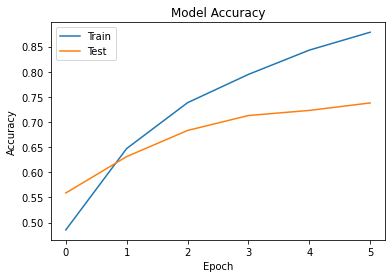

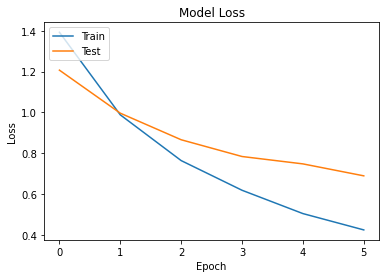

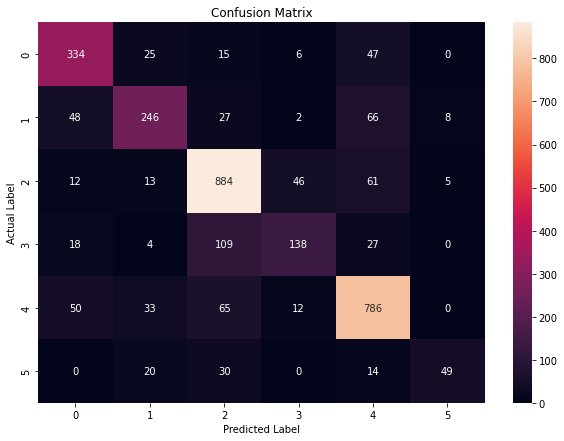

Epoch 1/6
80/80 [==============================] - 2s 14ms/step - loss: 1.3251 - acc: 0.5073 - val_loss: 1.0891 - val_acc: 0.6059
Epoch 2/6
80/80 [==============================] - 1s 11ms/step - loss: 0.8822 - acc: 0.6950 - val_loss: 0.8675 - val_acc: 0.6836
Epoch 3/6
80/80 [==============================] - 1s 11ms/step - loss: 0.6669 - acc: 0.7740 - val_loss: 0.7042 - val_acc: 0.7355
Epoch 4/6
80/80 [==============================] - 1s 11ms/step - loss: 0.5341 - acc: 0.8250 - val_loss: 0.6161 - val_acc: 0.7719
Epoch 5/6
80/80 [==============================] - 1s 11ms/step - loss: 0.4455 - acc: 0.8591 - val_loss: 0.5689 - val_acc: 0.7895
Epoch 6/6
100/100 [==============================] - 0s 3ms/step - loss: 0.5067 - acc: 0.8084
Test Score: 0.5067294836044312
Test Accuracy: 0.8084375262260437


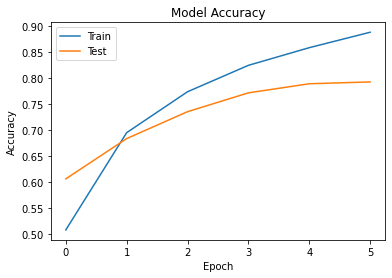

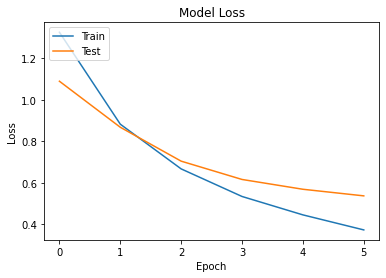

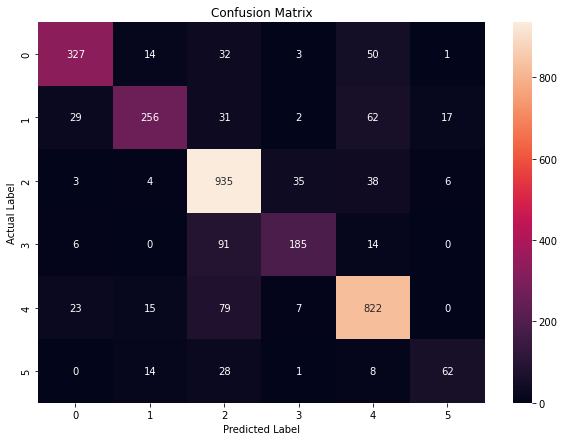

Epoch 1/6
80/80 [==============================] - 2s 16ms/step - loss: 1.3546 - acc: 0.4989 - val_loss: 1.1318 - val_acc: 0.5930
Epoch 2/6
80/80 [==============================] - 1s 13ms/step - loss: 0.8996 - acc: 0.6906 - val_loss: 0.9148 - val_acc: 0.6715
Epoch 3/6
80/80 [==============================] - 1s 13ms/step - loss: 0.6659 - acc: 0.7803 - val_loss: 0.7518 - val_acc: 0.7246
Epoch 4/6
80/80 [==============================] - 1s 16ms/step - loss: 0.5179 - acc: 0.8369 - val_loss: 0.6808 - val_acc: 0.7504
Epoch 5/6
80/80 [==============================] - 1s 15ms/step - loss: 0.4176 - acc: 0.8791 - val_loss: 0.6294 - val_acc: 0.7703
Epoch 6/6
100/100 [==============================] - 0s 4ms/step - loss: 0.5826 - acc: 0.7756
Test Score: 0.5825856924057007
Test Accuracy: 0.7756249904632568


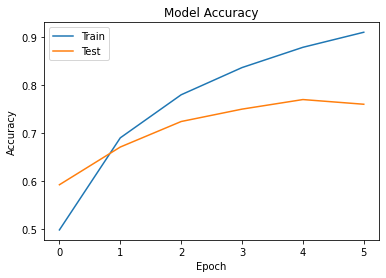

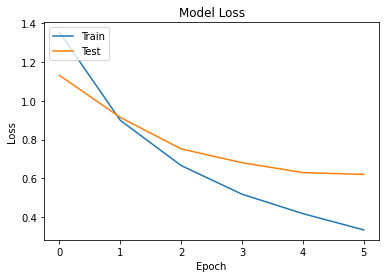

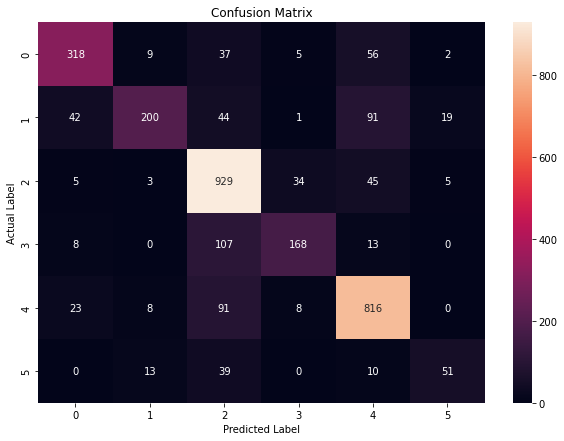

Epoch 1/6
80/80 [==============================] - 2s 18ms/step - loss: 1.3219 - acc: 0.5056 - val_loss: 1.1312 - val_acc: 0.5801
Epoch 2/6
80/80 [==============================] - 1s 16ms/step - loss: 0.8688 - acc: 0.7002 - val_loss: 0.8824 - val_acc: 0.6797
Epoch 3/6
80/80 [==============================] - 1s 15ms/step - loss: 0.6347 - acc: 0.7950 - val_loss: 0.7676 - val_acc: 0.7145
Epoch 4/6
80/80 [==============================] - 1s 15ms/step - loss: 0.4843 - acc: 0.8570 - val_loss: 0.7066 - val_acc: 0.7371
Epoch 5/6
80/80 [==============================] - 1s 15ms/step - loss: 0.3708 - acc: 0.9024 - val_loss: 0.6510 - val_acc: 0.7500
Epoch 6/6
100/100 [==============================] - 0s 3ms/step - loss: 0.5777 - acc: 0.7897
Test Score: 0.5776618719100952
Test Accuracy: 0.7896875143051147


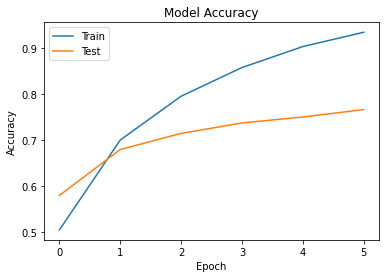

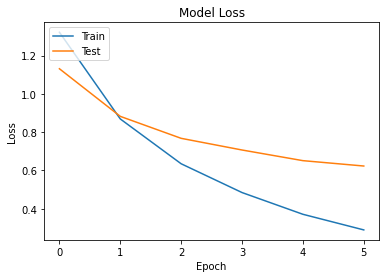

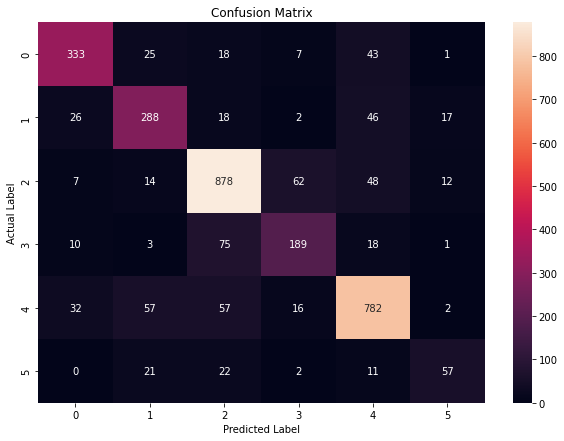

Epoch 1/6
80/80 [==============================] - 2s 23ms/step - loss: 1.2697 - acc: 0.5345 - val_loss: 1.0175 - val_acc: 0.6336
Epoch 2/6
80/80 [==============================] - 2s 21ms/step - loss: 0.7783 - acc: 0.7319 - val_loss: 0.7558 - val_acc: 0.7168
Epoch 3/6
80/80 [==============================] - 1s 17ms/step - loss: 0.5651 - acc: 0.8143 - val_loss: 0.6367 - val_acc: 0.7715
Epoch 4/6
80/80 [==============================] - 1s 17ms/step - loss: 0.4396 - acc: 0.8594 - val_loss: 0.5616 - val_acc: 0.7926
Epoch 5/6
80/80 [==============================] - 1s 17ms/step - loss: 0.3499 - acc: 0.8972 - val_loss: 0.5304 - val_acc: 0.8012
Epoch 6/6
100/100 [==============================] - 0s 3ms/step - loss: 0.4361 - acc: 0.8431
Test Score: 0.4361012578010559
Test Accuracy: 0.8431249856948853


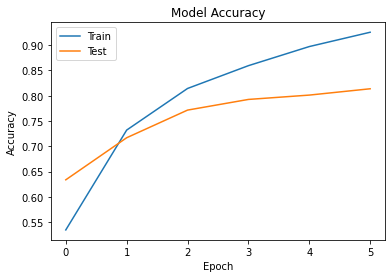

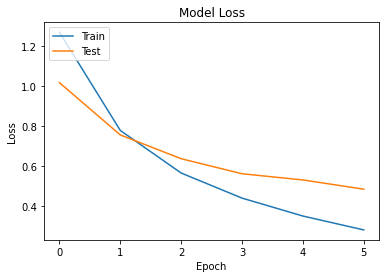

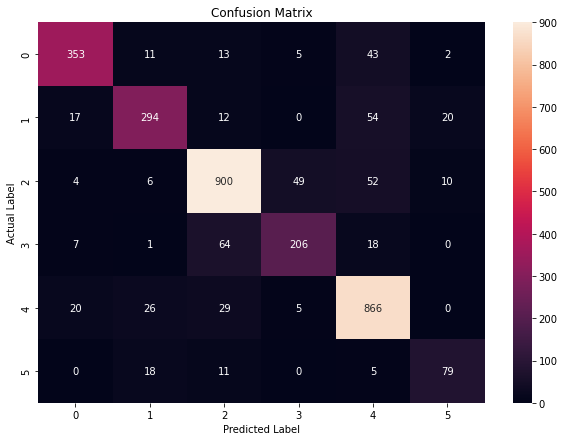

Epoch 1/6
80/80 [==============================] - 2s 26ms/step - loss: 1.2502 - acc: 0.5401 - val_loss: 1.0268 - val_acc: 0.6266
Epoch 2/6
80/80 [==============================] - 2s 25ms/step - loss: 0.7742 - acc: 0.7322 - val_loss: 0.8343 - val_acc: 0.6723
Epoch 3/6
80/80 [==============================] - 2s 25ms/step - loss: 0.5423 - acc: 0.8243 - val_loss: 0.6719 - val_acc: 0.7555
Epoch 4/6
80/80 [==============================] - 2s 26ms/step - loss: 0.3975 - acc: 0.8897 - val_loss: 0.6326 - val_acc: 0.7543
Epoch 5/6
80/80 [==============================] - 2s 20ms/step - loss: 0.2957 - acc: 0.9264 - val_loss: 0.5650 - val_acc: 0.7973
Epoch 6/6
100/100 [==============================] - 0s 4ms/step - loss: 0.5251 - acc: 0.7997
Test Score: 0.5250832438468933
Test Accuracy: 0.7996875047683716


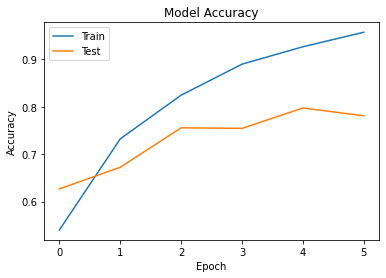

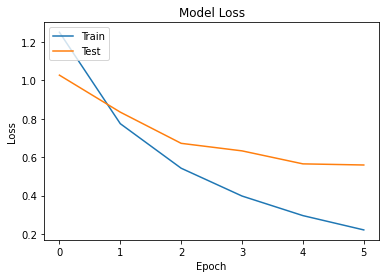

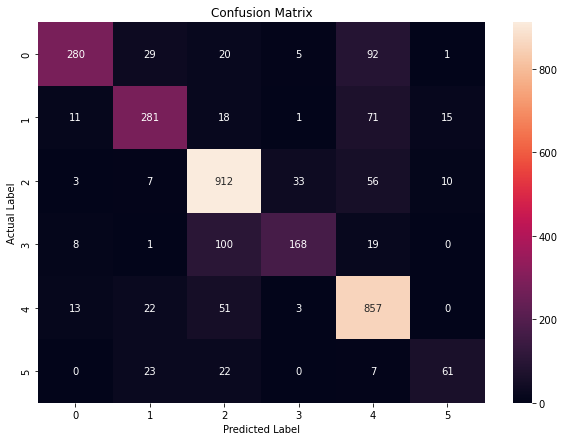

Epoch 1/6
80/80 [==============================] - 3s 30ms/step - loss: 1.3200 - acc: 0.5244 - val_loss: 1.0575 - val_acc: 0.6070
Epoch 2/6
80/80 [==============================] - 2s 30ms/step - loss: 0.7996 - acc: 0.7289 - val_loss: 0.8410 - val_acc: 0.6910
Epoch 3/6
80/80 [==============================] - 2s 29ms/step - loss: 0.5476 - acc: 0.8308 - val_loss: 0.7089 - val_acc: 0.7395
Epoch 4/6
80/80 [==============================] - 3s 31ms/step - loss: 0.3789 - acc: 0.9018 - val_loss: 0.6489 - val_acc: 0.7566
Epoch 5/6
80/80 [==============================] - 2s 30ms/step - loss: 0.2601 - acc: 0.9445 - val_loss: 0.6045 - val_acc: 0.7734
Epoch 6/6
100/100 [==============================] - 1s 4ms/step - loss: 0.5673 - acc: 0.7819
Test Score: 0.567333996295929
Test Accuracy: 0.7818750143051147


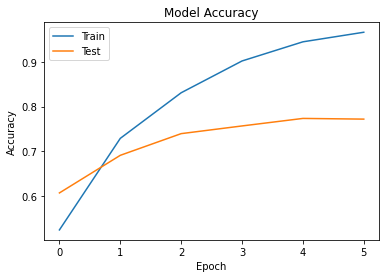

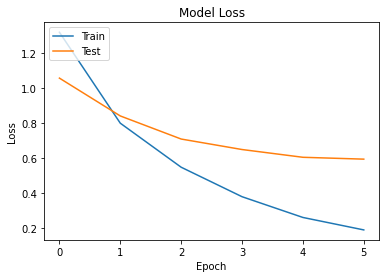

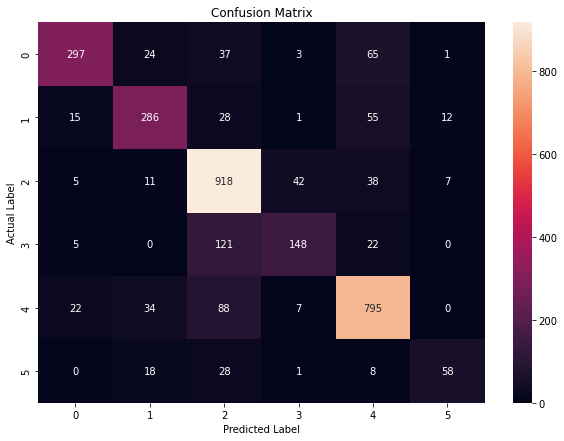

   Filters  Kernel_Size  Accuracy      Loss
0       64            3  0.794375  0.553796
1       64            5  0.775937  0.609681
2       64            7  0.761563  0.649800
3      128            3  0.808438  0.506729
4      128            5  0.775625  0.582586
5      128            7  0.789688  0.577662
6      256            3  0.843125  0.436101
7      256            5  0.799688  0.525083
8      256            7  0.781875  0.567334


In [50]:
def evaluate_hyperparameters(filter_values, kernel_sizes, X_train, y_train, X_test, y_test, embedding_layer):
    results = []

    for filters in filter_values:
        for kernel in kernel_sizes:
            model, history = train_Multiclass_CNN_Original(embedding_layer, X_train, y_train, filters, kernel)
            evaluation = evaluate_Multiclass_CNN(model, history, X_test, y_test)
            accuracy = evaluation[1]  
            loss = evaluation[0] 

            # Store results in a dictionary
            result = {
                'Filters': filters,
                'Kernel_Size': kernel,
                'Accuracy': accuracy,
                'Loss': loss
               
            }
            results.append(result)

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Define ranges
filter_values = [64, 128, 256]
kernel_sizes = [3, 5, 7]

# Run the hyperparameter optimization and get the DataFrame
results_df = evaluate_hyperparameters(filter_values, kernel_sizes, X_train_emotions, y_train_emotions, X_test_emotions, y_test_emotions, embedding_layer_emotions)                              
print(results_df)

Epoch 1/6
80/80 [==============================] - 4s 34ms/step - loss: 1.2879 - acc: 0.5245 - val_loss: 0.9972 - val_acc: 0.6379
Epoch 2/6
80/80 [==============================] - 2s 19ms/step - loss: 0.7788 - acc: 0.7313 - val_loss: 0.7434 - val_acc: 0.7266
Epoch 3/6
80/80 [==============================] - 2s 20ms/step - loss: 0.5632 - acc: 0.8176 - val_loss: 0.6226 - val_acc: 0.7723
Epoch 4/6
80/80 [==============================] - 2s 19ms/step - loss: 0.4378 - acc: 0.8642 - val_loss: 0.5647 - val_acc: 0.7898
Epoch 5/6
80/80 [==============================] - 1s 17ms/step - loss: 0.3486 - acc: 0.8972 - val_loss: 0.5036 - val_acc: 0.8055
Epoch 6/6
100/100 [==============================] - 0s 3ms/step - loss: 0.4607 - acc: 0.8297
Test Score: 0.4606625735759735
Test Accuracy: 0.8296874761581421


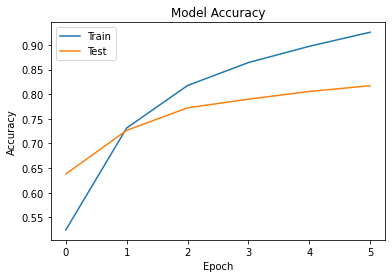

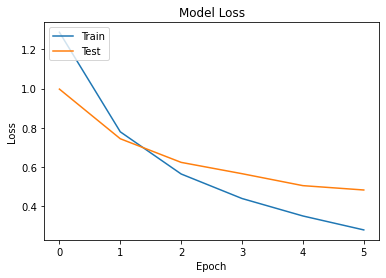

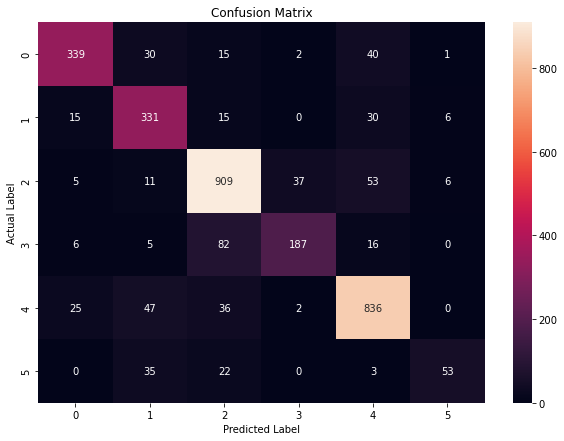

[0.4606625735759735, 0.8296874761581421]

In [52]:
cnn_multiclass_model1, cnn_multiclass_model_history1 = train_Multiclass_CNN_Original(embedding_layer_emotions, X_train_emotions, y_train_emotions, filters=256, kernel = 3)
evaluate_Multiclass_CNN(cnn_multiclass_model1, cnn_multiclass_model_history1, X_test_emotions, y_test_emotions)

Epoch 1/100
320/320 [==============================] - 4s 9ms/step - loss: 1.1269 - acc: 0.5903 - val_loss: 0.8898 - val_acc: 0.6633
Epoch 2/100
320/320 [==============================] - 2s 7ms/step - loss: 0.6209 - acc: 0.7882 - val_loss: 0.6481 - val_acc: 0.7602
Epoch 3/100
320/320 [==============================] - 2s 7ms/step - loss: 0.4080 - acc: 0.8700 - val_loss: 0.5949 - val_acc: 0.7773
Epoch 4/100
320/320 [==============================] - 2s 7ms/step - loss: 0.2724 - acc: 0.9257 - val_loss: 0.5359 - val_acc: 0.7906
Epoch 5/100
320/320 [==============================] - 2s 7ms/step - loss: 0.1857 - acc: 0.9572 - val_loss: 0.6047 - val_acc: 0.7785
Epoch 6/100
320/320 [==============================] - 2s 7ms/step - loss: 0.1309 - acc: 0.9760 - val_loss: 0.5397 - val_acc: 0.7934
Epoch 7/100
320/320 [==============================] - 2s 7ms/step - loss: 0.0898 - acc: 0.9857 - val_loss: 0.5269 - val_acc: 0.8098
Epoch 8/100
320/320 [==============================] - 2s 7ms/step - 

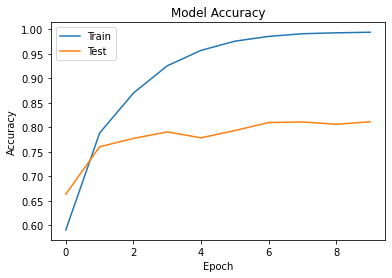

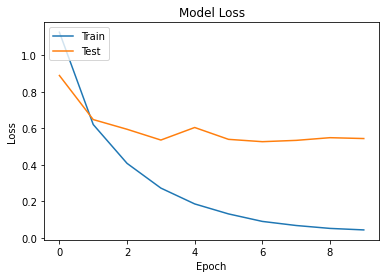

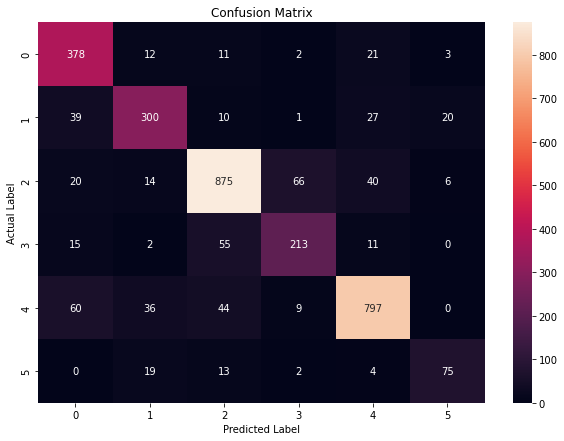

[0.4847019910812378, 0.8243749737739563]

In [53]:
def train_Multiclass_CNN_Original_earlystop(embedding_layer, X_train, y_train, filters = 256, kernel = 3):
    # Define the model
    cnn_multiclass_model = Sequential()
    cnn_multiclass_model.add(embedding_layer)
    cnn_multiclass_model.add(Conv1D(128, 5, activation='relu'))
    cnn_multiclass_model.add(GlobalMaxPooling1D())
    cnn_multiclass_model.add(Dense(len(y_train.columns), activation='softmax')) #One output neuron per class

    # Compile the model
    cnn_multiclass_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


    # Train the model
    cnn_multiclass_model_history = cnn_multiclass_model.fit(X_train, y_train, callbacks=[early_stopping], epochs=100, validation_split=0.2)

    return cnn_multiclass_model, cnn_multiclass_model_history

cnn_multiclass_model2, cnn_multiclass_model_history2 = train_Multiclass_CNN_Original_earlystop(embedding_layer_emotions, X_train_emotions, y_train_emotions)
evaluate_Multiclass_CNN(cnn_multiclass_model2, cnn_multiclass_model_history2, X_test_emotions, y_test_emotions)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 66, 100)           1339900   
                                                                 
 conv1d_19 (Conv1D)          (None, 64, 256)           77056     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 32, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_20 (Conv1D)          (None, 30, 256)           196864    
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 15, 256)           0         
 g1D)                                                            
                                                                 
 global_max_pooling1d_18 (G  (None, 256)             

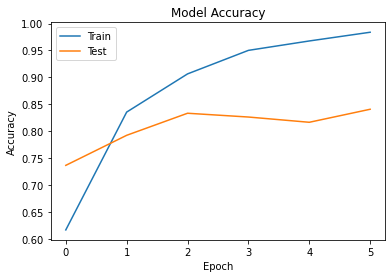

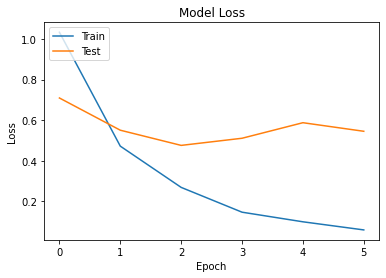

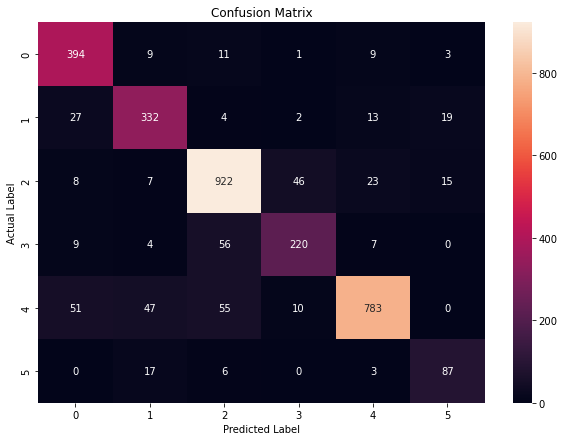

[0.410835862159729, 0.8556249737739563]

In [55]:
def train_Multiclass_CNN(embedding_layer, X_train, y_train, filters = 256, kernel = 3, num_conv_layers=2, epochs=6):
    cnn_model = Sequential()
    cnn_model.add(embedding_layer)
    
    for _ in range(num_conv_layers):
        cnn_model.add(Conv1D(filters, kernel, activation='relu'))
        cnn_model.add(MaxPooling1D())
    
    cnn_model.add(GlobalMaxPooling1D()) 
    
    cnn_model.add(Dense(len(y_train.columns), activation='softmax'))

    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    
    print(cnn_model.summary())

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    cnn_model_history = cnn_model.fit(X_train, y_train, epochs=100, callbacks=[early_stopping], validation_split=0.2)

    return cnn_model, cnn_model_history

cnn_multiclass_model3, cnn_multiclass_model_history3 = train_Multiclass_CNN(embedding_layer_emotions, X_train_emotions, y_train_emotions)
evaluate_Multiclass_CNN(cnn_multiclass_model3, cnn_multiclass_model_history3, X_test_emotions, y_test_emotions)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 66, 100)           1339900   
                                                                 
 conv1d_21 (Conv1D)          (None, 64, 256)           77056     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 32, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_22 (Conv1D)          (None, 30, 256)           196864    
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 15, 256)           0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 3840)            

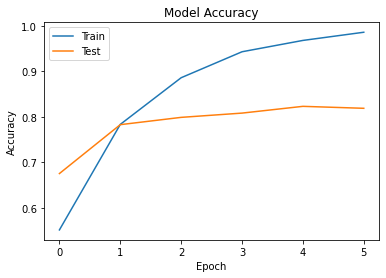

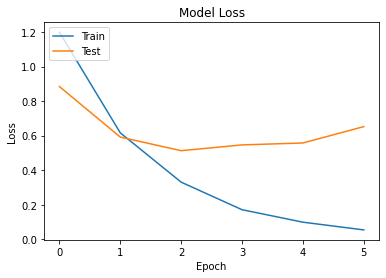

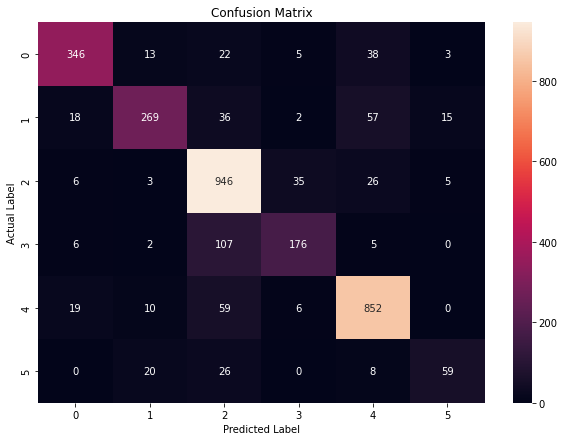

[0.45249560475349426, 0.8274999856948853]

In [56]:
def train_Multiclass_CNN_flattening(embedding_layer, X_train, y_train, filters=256, kernel=3, num_conv_layers=2, epochs=6):
    cnn_model = Sequential()
    cnn_model.add(embedding_layer)
    
    for _ in range(num_conv_layers):
        cnn_model.add(Conv1D(filters, kernel, activation='relu'))
        cnn_model.add(MaxPooling1D())
    
    cnn_model.add(Flatten()) 
    
    cnn_model.add(Dense(len(y_train.columns), activation='softmax'))

    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    
    print(cnn_model.summary())

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    cnn_model_history = cnn_model.fit(X_train, y_train, epochs=100, callbacks=[early_stopping], validation_split=0.2)

    return cnn_model, cnn_model_history

cnn_multiclass_model5, cnn_multiclass_model_history5 = train_Multiclass_CNN_flattening(embedding_layer_emotions, X_train_emotions, y_train_emotions)
evaluate_Multiclass_CNN(cnn_multiclass_model5, cnn_multiclass_model_history5, X_test_emotions, y_test_emotions)

# Analysing sentences

In [67]:
def analyseSentenseBinaryCCN(new_sentence, model, maxlen):
    # Tokenize and convert to numeric form
    new_sentence_seq = word_tokenizer.texts_to_sequences([new_sentence])
    
    # Padding the new sentence to match the maxlen used during training
    padded_new_sentence = pad_sequences(new_sentence_seq, padding='post', maxlen=maxlen)

    # Predict the sentiment probabilities
    predicted_probabilities = model.predict(padded_new_sentence)
    predicted_probabilities_rounded =  np.round(predicted_probabilities).astype(int)
    

    # Find the class with the maximum probability
    predicted_sentiment = np.argmax(predicted_probabilities_rounded, axis=1)
    '''
    print("new_sentence_seq:", new_sentence_seq)
    print("padded_new_sentence:", padded_new_sentence)
    print("Predicted Sentiment:", predicted_sentiment)
    print("Predicted Probabilities:", predicted_probabilities)
    print("predicted_probabilities_rounded", predicted_probabilities_rounded)
    '''
    # Map the predicted sentiment to the corresponding class or label
    predicted_class = class_mapping[int(predicted_probabilities_rounded[0])]

    print("Predicted Class:", predicted_class, " at", float(predicted_probabilities)*100, "% ")
    return predicted_class

analyseSentenseBinaryCCN("this was very red", cnn_model2, max_words_count_movies)

1/1 [==============================] - 0s 83ms/step
Predicted Class: negative  at 48.72466027736664 % 


'negative'